## <p style="text-align:left;font-weight:500;">AI/ML Mini Project (Exp 9 & 10)</p>  
### <p style="text-align:left;font-weight:300;">Topic: Alzheimer's Disease Detection</p>   
<p style="text-align:left;font-weight:400;">Team Members: </p>  
<p style="text-align:left;font-weight:400;">1. Hatim Sawai (2021300108)</p>  
<p style="text-align:left;font-weight:400;">2. Tathagat Sengupta (2021300110)</p>  
<p style="text-align:left;font-weight:400;">3. Sahil Shah (2021300115)</p>  

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator as IDG

### Importing Dataset

In [5]:
BASE_DIR = "./data/"
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
datagen = IDG(
    rescale = 1./255, 
    brightness_range=[0.8, 1.2], 
    zoom_range=[.99, 1.01], 
    data_format="channels_last", 
    fill_mode='constant',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(directory=TRAIN_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [8]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()
#Getting to know the dimensions of our dataset
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


### Splitting Dataset into Training and Testing Sets (80:20)

In [9]:
#Splitting the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Model Building

In [10]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [11]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
CALLBACKS = [my_callback]

In [12]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()




Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                      

### Model Evaluation

In [13]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
model.save('alzheimer_model.h5')

Epoch 1/50

103/103 [==============================] - 190s 2s/step - loss: 1.7342 - acc: 0.3223 - auc: 0.5700 - val_loss: 1.3618 - val_acc: 0.4841 - val_auc: 0.6245
Epoch 2/50
103/103 [==============================] - 155s 2s/step - loss: 1.3533 - acc: 0.4158 - auc: 0.6823 - val_loss: 1.6111 - val_acc: 0.3768 - val_auc: 0.7032
Epoch 3/50
103/103 [==============================] - 144s 1s/step - loss: 1.1672 - acc: 0.4850 - auc: 0.7576 - val_loss: 1.0724 - val_acc: 0.4939 - val_auc: 0.7958
Epoch 4/50
103/103 [==============================] - 140s 1s/step - loss: 1.0802 - acc: 0.5079 - auc: 0.7902 - val_loss: 1.8122 - val_acc: 0.5000 - val_auc: 0.7820
Epoch 5/50
103/103 [==============================] - 140s 1s/step - loss: 1.0261 - acc: 0.5140 - auc: 0.8050 - val_loss: 1.1497 - val_acc: 0.4049 - val_auc: 0.7064
Epoch 6/50
103/103 [==============================] - 137s 1s/step - loss: 0.9732 - acc: 0.5394 - auc: 0.8223 - val_loss: 1.6266 - val_acc: 0.4854 - val_auc: 0.8108
Epoch 7/5

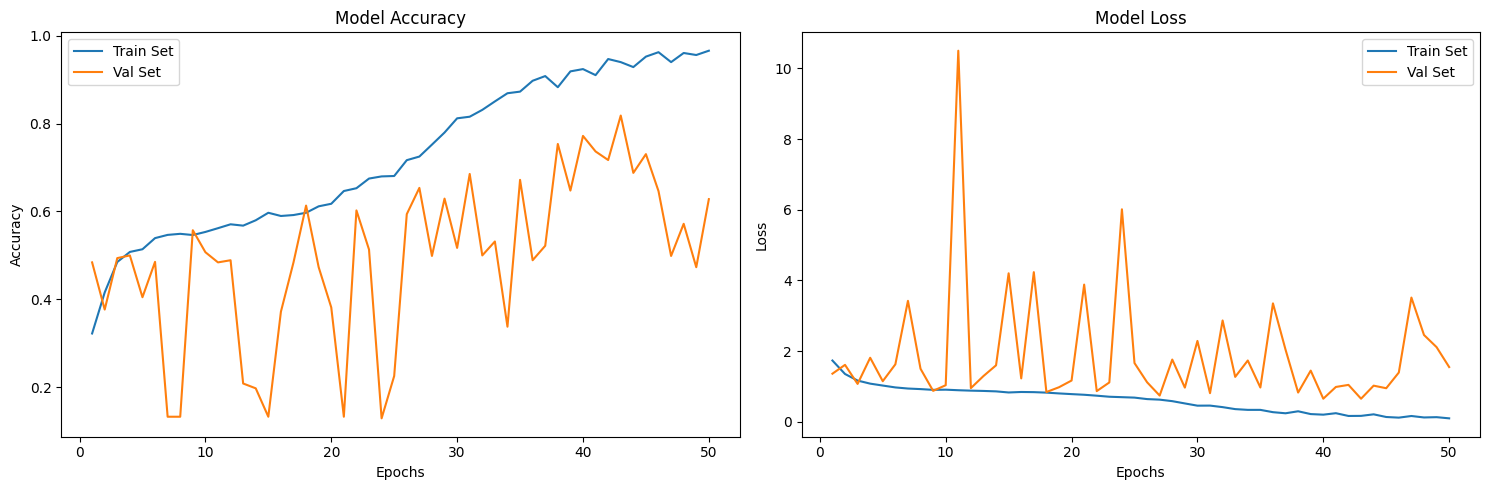

In [14]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Model Testing

In [15]:
#Predicting the test data

pred_labels = model.predict(test_data)

33/33 [==============================] - 12s 224ms/step


[[ 29   1  52  77]
 [  0   4  11   1]
 [  0   0 491   8]
 [  0   0 204 147]]


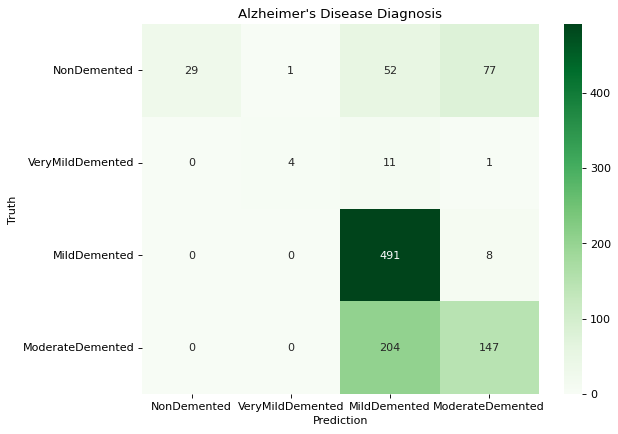

In [16]:
#Plot the confusion matrix to understand the classification in detail
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
print(conf_arr)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Model Demo

In [7]:
# test the model with an image stored in data_preview
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

model = load_model('alzheimer_model.h5')
img = image.load_img('./data_preview/alzheimer/VeryMildDemented/verymildDem1.jpg', target_size=(176, 176))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

pred = model.predict(img)
index = pred[0].argmax()
outputs = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
print("Prediction: ", outputs[index])

1/1 [==============================] - 0s 395ms/step
Prediction:  Very Mild Demented
